In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#data dependencies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk


In [0]:
#Aunthenticate

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Training Link : https://drive.google.com/open?id=1NWrf1adDUBbA5MM3q-gqr0bZu1SrtILX
# Testing Link : https://drive.google.com/open?id=1RHIIZ34VGN5BEha3_OMSq4CmVVxvY-Fm

train_downloaded = drive.CreateFile({'id':'1NWrf1adDUBbA5MM3q-gqr0bZu1SrtILX'})
train_downloaded.GetContentFile('clean_tweet_training.csv')
test_downloaded = drive.CreateFile({'id':'1RHIIZ34VGN5BEha3_OMSq4CmVVxvY-Fm'})
test_downloaded.GetContentFile('clean_tweet_testing.csv')

In [5]:
train_df = pd.read_csv('clean_tweet_training.csv', index_col='index')
test_df = pd.read_csv('clean_tweet_testing.csv', index_col='index')

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
train_df.head()

,text,target
index,,
0,awww bummer shoulda got david carr third day,0
1,upset update facebook texting might cry result...,0
2,dived many times ball managed save rest go bounds,0
3,whole body feels itchy like fire,0
4,behaving mad see,0


In [7]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm

# replace urls
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
re.MULTILINE|re.UNICODE)
# replace ips
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")
# setup tokenizer
tokenizer = WordPunctTokenizer()
vocab = Counter()

def text_to_wordlist(text, lower=False):
    # replace URLs
    text = re_url.sub("URL", text)
    # replace IPs
    text = re_ip.sub("IPADDRESS", text)
    # Tokenize
    text = tokenizer.tokenize(text)
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
        # Return a list of words
        vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments

list_sentences_train = list(train_df["text"].fillna("NAN_WORD").values)
list_sentences_test = list(test_df["text"].fillna("NAN_WORD").values)
comments = process_comments(list_sentences_train + list_sentences_test, lower=True)

  0%|          | 0/1600498 [00:00<?, ?it/s]

Processing text dataset


100%|██████████| 1600498/1600498 [00:21<00:00, 75992.44it/s]


In [8]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))

The vocabulary contains 273627 unique tokens


In [0]:
from gensim.models import Word2Vec

In [10]:
%%time

model = Word2Vec(comments, size=100, window=5, min_count=3, workers=16, sg=0, negative=5)

CPU times: user 2min 48s, sys: 656 ms, total: 2min 48s
Wall time: 1min 32s


In [0]:
word_vectors = model.wv

In [12]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 76937


In [13]:
model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])

[('williams', 0.9379151463508606),
 ('roach', 0.9321208596229553),
 ('baker', 0.9091166853904724),
 ('eddings', 0.9026027321815491),
 ('adams', 0.9013794660568237),
 ('turner', 0.9011590480804443),
 ('edwards', 0.8980621099472046),
 ('bush', 0.8978574275970459),
 ('cradle', 0.8934661746025085),
 ('cohen', 0.8926040530204773)]

In [0]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

In [15]:
from keras.preprocessing.sequence import pad_sequences

word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_train):]]

# pad
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
list_classes = ["target"]
y = train_df[list_classes].values
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")
print('Shape of test_data tensor:', test_data.shape)

Using TensorFlow backend.


Shape of data tensor: (1600000, 200)
Shape of label tensor: (1600000, 1)
Shape of test_data tensor: (498, 200)


In [0]:
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))
# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass      

In [0]:
from keras.layers import Dense, Input, Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout, Embedding, SpatialDropout1D, CuDNNLSTM, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

In [18]:
wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = wv_layer(comment_input)

# Embedded
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)

#Convolutional1D
x = Conv1D(filters=3, kernel_size=64, strides=1, padding='valid', data_format='channels_last', dilation_rate=1, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(embedded_sequences)

#MaxPoolingLayer1D
x = MaxPooling1D(pool_size=2, strides=None, padding='valid', data_format='channels_last')(x)

#DropoutLayers
x = Dropout(rate=0, noise_shape=None, seed=None)(x)

#BatchNormalization
x = BatchNormalization()(x)

#LSTM
x = LSTM(units=128, activation='relu', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=1, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)(x)

preds = Dense(1, activation='relu')(x)

# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
hist = model.fit([data], y, validation_split=0.1, epochs=8, batch_size=256, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 1440000 samples, validate on 160000 samples
Epoch 1/8
1440000/1440000 [==============================] - 692s 480us/step - loss: 0.5832 - acc: 0.6899 - val_loss: 0.6810 - val_acc: 0.5632
Epoch 2/8
1440000/1440000 [==============================] - 685s 476us/step - loss: 0.5703 - acc: 0.6966 - val_loss: 0.6466 - val_acc: 0.5899
Epoch 3/8
1440000/1440000 [==============================] - 687s 477us/step - loss: 0.5702 - acc: 0.6975 - val_loss: 0.6624 - val_acc: 0.5907
Epoch 4/8
1440000/1440000 [==============================] - 679s 472us/step - loss: 0.5676 - acc: 0.6987 - val_loss: 0.6214 - val_acc: 0.6219
Epoch 5/8
1440000/1440000 [==============================] - 684s 475us/step - loss: 0.5840 - acc: 0.6982 - val_loss: 0.6572 - val_acc: 0.5894
Epoch 6/8
1440000/1440000 [==============================] - 685s 476us/step - loss: 0.5661 - acc: 0.6996 - val_loss: 0.6157 - val_acc: 0.6263
Epoch 7/8
1440000/1440000 [==============

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          7693700   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 137, 3)            19203     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 68, 3)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 68, 3)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 68, 3)             12        
__________

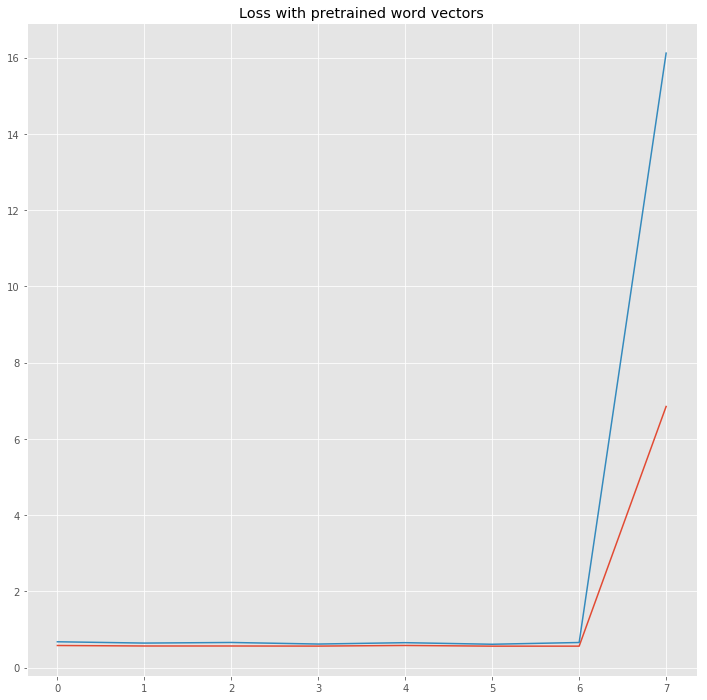

In [21]:
history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12));
plt.plot(history["loss"]);
plt.plot(history["val_loss"]);
plt.title("Loss with pretrained word vectors");
plt.show();

In [26]:
acc = history.iloc[0:6,3]
loss = history.iloc[0:6,2]
history

,val_loss,val_acc,loss,acc
0,0.680986,0.563231,0.583179,0.689940
1,0.646602,0.589925,0.570294,0.696612
2,0.662425,0.590725,0.570202,0.697497
3,0.621370,0.621856,0.567568,0.698735
4,0.657192,0.589437,0.583963,0.698237
5,0.615685,0.626350,0.566093,0.699591
6,0.661602,0.607581,0.566119,0.699933
7,16.118095,0.000000,6.851357,0.562269


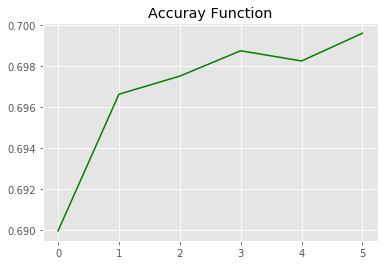

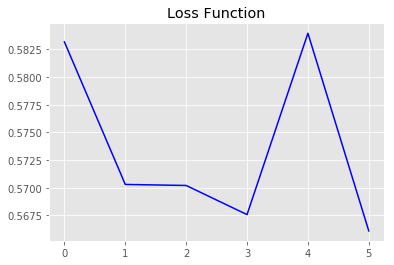

In [31]:
plt.plot(acc, color='g');
# plt.plot(loss, color='blue');
plt.title("Accuray Function");
plt.show();
# plt.plot(acc, color='g');
plt.plot(loss, color='blue');
plt.title("Loss Function");
plt.show();